## Clustering

Hierarchical and K-Means clustering on thermal data and on thermal data

In [237]:
# 0. Load libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import sklearn.preprocessing
import numpy as np
import seaborn as sns

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

import requests
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import requests

import gzip, shutil
import rasterio
import os, requests, gzip, shutil, rasterio
from rasterio.merge import merge

import os, requests, gzip, shutil
import rasterio
from rasterio.merge import merge
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA



In [238]:
# 1. Load 
MASTER_PATH = "/Users/moritzknodler/Documents/00_Lectures/0_Fall 2025/ML/z_Project/Flight data/thermals/thermals_master_with_weather_PCA.csv"

df = pd.read_csv(MASTER_PATH)

# Display first few rows
display(df.tail())

# Show all column names as comma-separated string
print(", ".join(df.columns))
print(f"Columns: {len(df.columns)}", f"Rows: {len(df)}")


,thermal_id,flight_id,start_datetime,start_time,end_time,duration_s,avg_climb,max_climb,climb_std,avg_turn_radius,...,shortwave_radiation,boundary_layer_height,PC1,PC2,PC3,PC4,PC5,entry_agl,exit_agl,entry_terrain_alt
7878,7879,3478186,2024-12-30 12:42:19,2784,2843,44,1.201435,3.8,0.835286,52.179048,...,343.0,40.0,-5.219762,-1.032469,1.369053,0.410853,-0.978504,186.0,202.0,2221.0
7879,7880,3478186,2024-12-30 12:51:47,3048,3100,30,1.444462,3.6,0.767783,54.397909,...,341.0,60.0,-4.880234,-1.021075,1.690748,0.526618,-1.700047,108.0,119.0,2153.0
7880,7881,3478186,2024-12-30 12:55:22,3147,3162,15,1.262500,2.2,0.503581,-34.545109,...,341.0,60.0,-4.706574,-0.961984,1.730406,0.495304,-1.704153,198.0,220.0,2078.0
7881,7882,3478186,2024-12-30 13:00:44,3296,3366,56,1.304190,1.4,1.189283,-48.100767,...,341.0,60.0,-4.815111,-0.998916,1.705620,0.514875,-1.701587,115.0,115.0,2104.0
7882,7883,3478186,2024-12-30 13:04:40,3406,3583,116,1.642419,1.0,0.909839,-39.054873,...,343.0,40.0,-5.099932,-0.993426,1.396783,0.389725,-0.981459,139.0,140.0,2144.0


thermal_id, flight_id, start_datetime, start_time, end_time, duration_s, avg_climb, max_climb, climb_std, avg_turn_radius, avg_turn, turn_std, lat_center, lon_center, entry_alt, exit_alt, alt_gain, thermal_quality, time, temperature_2m, dewpoint_2m, windspeed_10m, winddirection_10m, cloudcover_low, cloudcover_mid, cloudcover_high, shortwave_radiation, boundary_layer_height, PC1, PC2, PC3, PC4, PC5, entry_agl, exit_agl, entry_terrain_alt
Columns: 36 Rows: 7883


In [239]:
# 2. Data cleaning 
df = df[df["entry_alt"] != 0]

df.loc[df["exit_agl"] == 0, "exit_agl"] = (
    df.loc[df["exit_agl"] == 0, "entry_agl"] + df.loc[df["exit_agl"] == 0, "alt_gain"]
)

# Remove unrealistic thermals avg_climb > 10 m/s, max_climb > 20 m/s
df = df[(df["avg_climb"] <= 10) & (df["max_climb"] <= 20)]


In [240]:
# Save data sample for sharing

cols_thermal = [
    "duration_s",        # thermal lifetime
    "avg_climb",         # mean climb rate
    "max_climb",         # strongest climb
    "climb_std",         # variability in climb rate
    "avg_turn",          # average turn rate (deg/s)
    "turn_std",          # turn rate variability
    "entry_alt",         # entry altitude (ASL)
    "exit_alt",          # exit altitude (ASL)
    "alt_gain",          # total altitude gain
    "entry_agl",         # entry above ground level
    "exit_agl",          # exit above ground level
    "entry_terrain_alt", # terrain at entry
    "thermal_quality"    # optional quality metric if available
]

# Select only the thermal-related columns
df_thermal = df[cols_thermal]

# Display the first few rows to confirm
display(df_thermal.head())

# Save the first 30 rows as a representative sample
df_thermal.head(30).to_csv("sample_thermal_dataset.csv", index=False)

,duration_s,avg_climb,max_climb,climb_std,avg_turn,turn_std,entry_alt,exit_alt,alt_gain,entry_agl,exit_agl,entry_terrain_alt,thermal_quality
0,251,1.445575,2.6,0.631151,6.047780,6.973388,1668,2044,362.0,60.0,127.0,1608.0,117.236782
1,23,0.823119,1.6,0.354334,22.050214,4.545925,1973,1996,20.0,274.0,287.0,1699.0,13.788889
2,67,1.743646,5.2,1.185881,17.530300,6.111728,1802,1936,121.0,294.0,387.0,1508.0,90.514286
3,99,1.078976,2.4,0.563373,10.943775,6.024201,1592,1701,105.0,182.0,269.0,1410.0,90.455000
4,99,0.863319,1.0,0.307944,-17.012640,4.143534,1675,1751,86.0,240.0,247.0,1435.0,7.818182


Total rows: 7,868

🧩 Missing Values Overview (before cleaning):


,NaN_count,Percentage
avg_climb,0,0.0
alt_gain,0,0.0
duration_s,0,0.0
entry_alt,0,0.0



⚠️ Total missing values: 0 (0.00% of all data points)

📊 Summary Statistics:


,count,mean,std,min,25%,50%,75%,max
avg_climb,7868.0,1.551323,0.694889,0.579512,1.095676,1.378923,1.809399,8.924408
alt_gain,7868.0,209.116802,211.607229,20.000000,53.000000,130.000000,297.000000,1688.000000
duration_s,7868.0,124.675521,106.632540,15.000000,42.000000,90.000000,175.250000,897.000000
entry_alt,7868.0,2035.730808,498.954297,467.000000,1708.000000,2012.000000,2335.000000,4142.000000


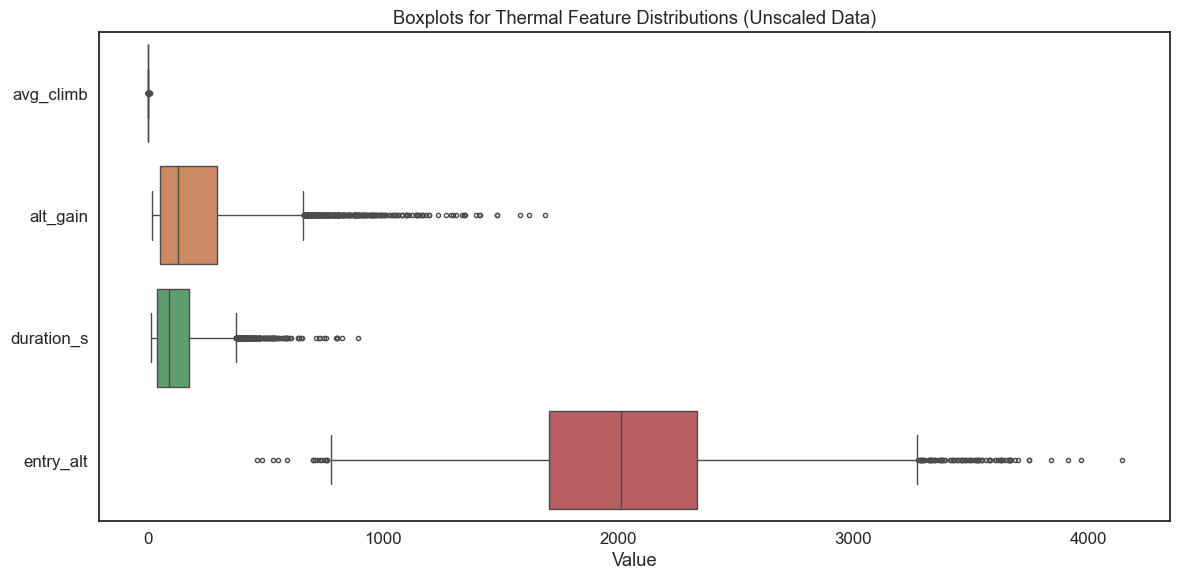

In [241]:
# 2. Scale data, Preprocess data for clustering


cols_thermal = [
    "duration_s",        # thermal lifetime
    "avg_climb",         # mean climb rate
    "max_climb",         # strongest climb
    "climb_std",         # variability in climb rate
    "avg_turn",          # average turn rate (deg/s)
    "turn_std",          # turn rate variability
    "entry_alt",         # entry altitude (ASL)
    "exit_alt",          # exit altitude (ASL)
    "alt_gain",          # total altitude gain
    "entry_agl",         # entry above ground level
    "exit_agl",          # exit above ground level
    "entry_terrain_alt", # terrain at entry
    "thermal_quality"    # optional quality metric if available
]

key_features = ["avg_climb", "alt_gain", "duration_s", "entry_alt"]

cols_thermal = key_features 

print(f"Total rows: {len(df):,}\n")

# 1️⃣ --- Missing values overview ---
nan_summary = (
    df[cols_thermal]
    .isna()
    .sum()
    .to_frame("NaN_count")
    .assign(Percentage=lambda x: 100 * x["NaN_count"] / len(df))
    .sort_values("NaN_count", ascending=False)
)

print("🧩 Missing Values Overview (before cleaning):")
display(nan_summary)

# Total NaN count summary
total_nans = nan_summary["NaN_count"].sum()
total_cells = len(df) * len(cols_thermal)
print(f"\n⚠️ Total missing values: {total_nans:,} "
      f"({100 * total_nans / total_cells:.2f}% of all data points)\n")

# 2️⃣ --- Summary statistics ---
print("📊 Summary Statistics:")
display(df[cols_thermal].describe().T)

# 3️⃣ --- Boxplot visualization ---
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[cols_thermal], orient="h", fliersize=3)
plt.title("Boxplots for Thermal Feature Distributions (Unscaled Data)")
plt.xlabel("Value")
plt.tight_layout()
plt.show()

In [242]:
# 3.0 Scale data
X_scaled = StandardScaler().fit_transform(df[cols_thermal])
len(X_scaled)


7868

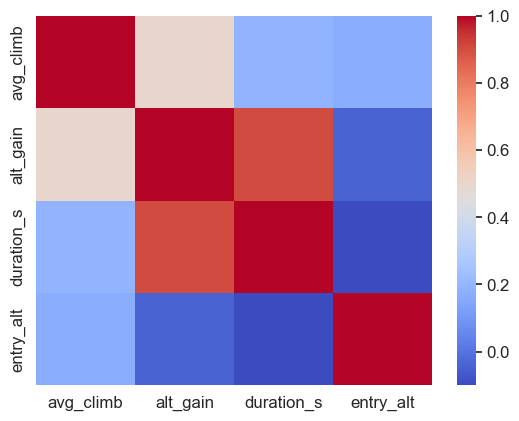

[0.53039495 0.81387579 0.9901866  1.        ]


In [243]:
# 3.1 Check correlations and PCA (how many PCs are relevant)

sns.heatmap(df[cols_thermal].corr(), cmap="coolwarm", annot=False)
plt.show()

pca = PCA().fit(X_scaled)
print(np.cumsum(pca.explained_variance_ratio_))



🚨 Outlier Counts per Column (|z| > 5):


avg_climb     37
alt_gain      16
duration_s    12
entry_alt      0
dtype: int64

⚠️ Total outlier values: 65 (0.21% of all cells)


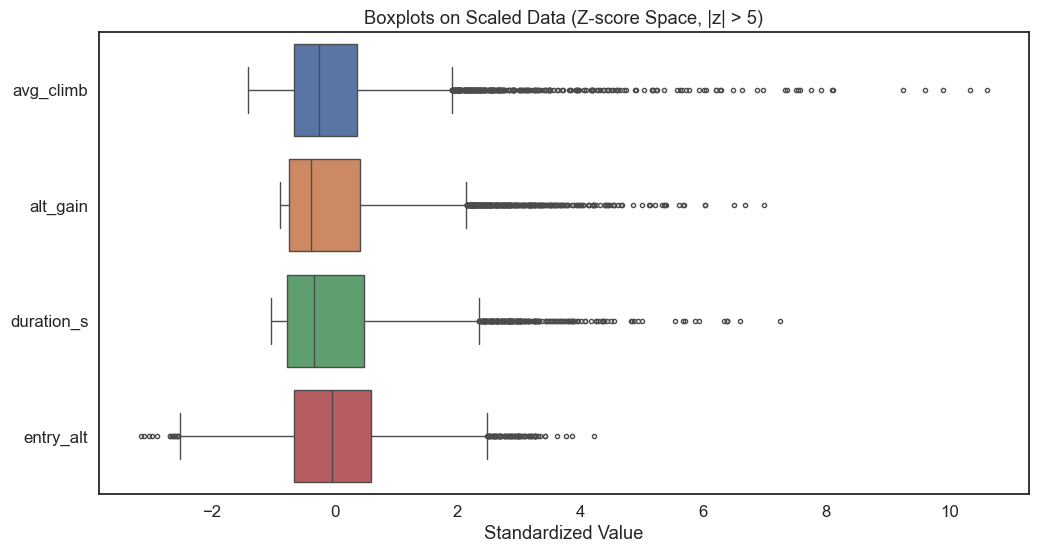

In [244]:
#3.3 Check data quality (missing values, outliers, basic stats)
# in scaled data space (z-score space)

# Convert scaled array into labeled DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=cols_thermal)

Z_THRESH = 5

# Detect outliers (|z| > threshold)
zscore_outliers = (np.abs(X_scaled_df) > Z_THRESH)

# Count outliers per column
outlier_counts = zscore_outliers.sum().sort_values(ascending=False)

print(f"\n🚨 Outlier Counts per Column (|z| > {Z_THRESH}):")
display(outlier_counts)

# Optional: overall outlier rate
total_outliers = zscore_outliers.sum().sum()
percent_outliers = 100 * total_outliers / X_scaled_df.size
print(f"⚠️ Total outlier values: {total_outliers:,} ({percent_outliers:.2f}% of all cells)")

# Visualize distributions
plt.figure(figsize=(12, 6))
sns.boxplot(data=X_scaled_df, orient="h", fliersize=3)
plt.title(f"Boxplots on Scaled Data (Z-score Space, |z| > {Z_THRESH})")
plt.xlabel("Standardized Value")
plt.show()

In [245]:
# Replace extreme values with NaN as before
Z_THRESH = 5
outlier_mask = np.abs(X_scaled_df) > Z_THRESH
X_scaled_df = X_scaled_df.mask(outlier_mask)

# Impute missing values with column means
X_scaled_df = X_scaled_df.fillna(X_scaled_df.mean())

print(f"✅ Imputed outliers (|z| > {Z_THRESH}) with column means.")
print(f"✅ Final shape for clustering: {X_scaled_df.shape}")

✅ Imputed outliers (|z| > 5) with column means.
✅ Final shape for clustering: (7868, 4)


In [246]:
# Save data sample for sharing
display(X_scaled_df.head())
X_scaled_df.head(30).to_csv("sample_dataset.csv", index=False)

,avg_climb,alt_gain,duration_s,entry_alt
0,-0.152189,0.722532,1.184746,-0.737050
1,-1.048008,-0.893773,-0.953574,-0.125733
2,0.276785,-0.416443,-0.540915,-0.468471
3,-0.679787,-0.492060,-0.240800,-0.889378
4,-0.990155,-0.581855,-0.240800,-0.723020


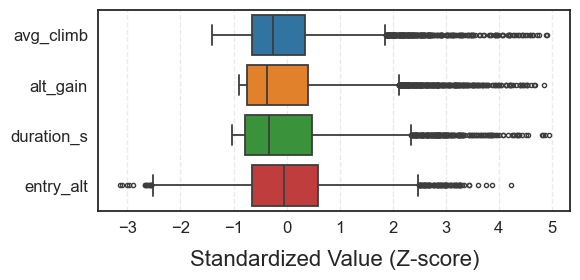

In [247]:
# Visualizing: bar plot of key features

# Define consistent colors (same as KMeans palette)
kmeans_colors = sns.color_palette("tab10", 5)
feature_colors = [kmeans_colors[i] for i in [0, 1, 2, 3]]  # four features

# Create the boxplot
plt.figure(figsize=(6, 3))
sns.boxplot(
    data=X_scaled_df[["avg_climb", "alt_gain", "duration_s", "entry_alt"]],
    orient="h",
    fliersize=3,
    linewidth=1.3,
    palette=feature_colors
)

# Larger labels
plt.xlabel("Standardized Value (Z-score)", fontsize=16, labelpad=10)
plt.ylabel("", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Optional grid for readability
plt.grid(axis="x", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()

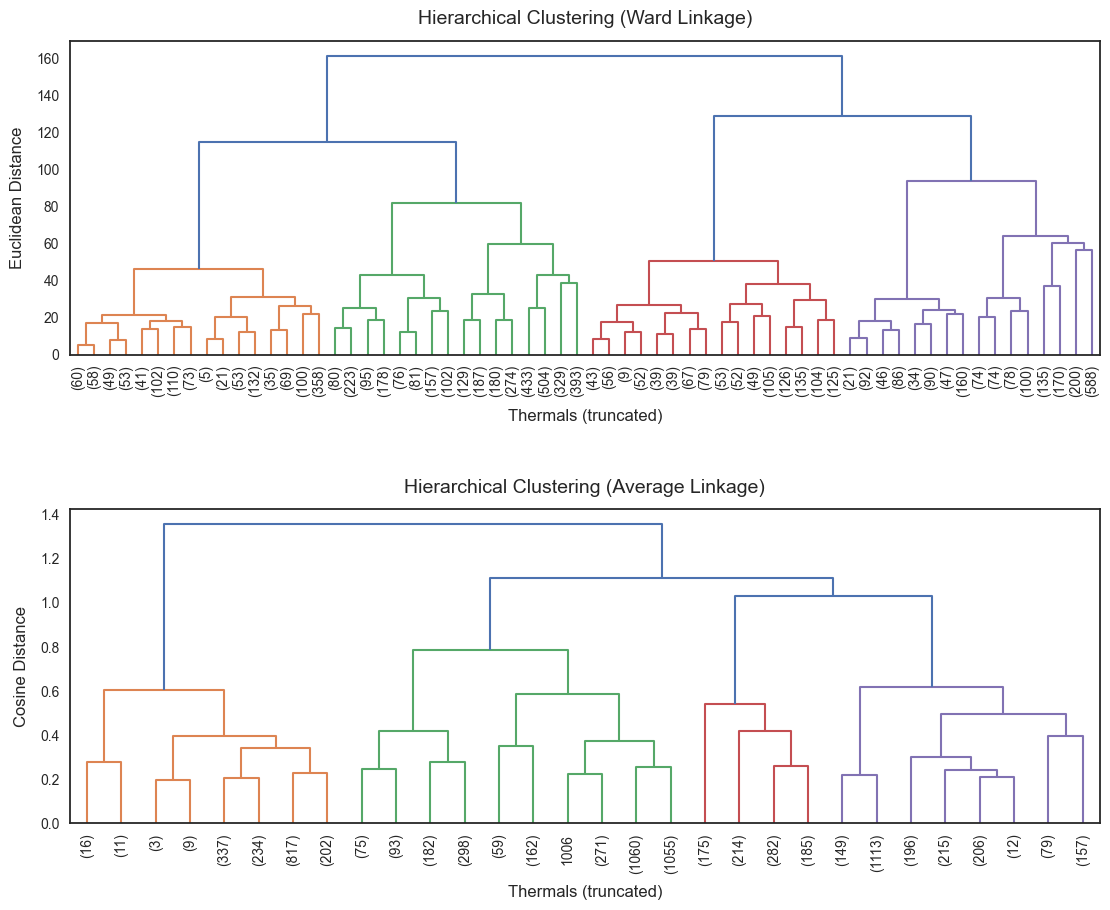

In [248]:
# 4. Hierarchical Clustering and Dendrograms

# Use consistent, clean style
sns.set(style="white", font_scale=1.1)
plt.rcParams.update({"axes.linewidth": 1.3, "xtick.major.size": 4, "ytick.major.size": 4})

# --- Compute linkage matrices ---
linkage_ward = linkage(df_scaled, method="ward")
dist_matrix_cosine = pdist(X_scaled_df, metric="cosine")
linkage_cosine = linkage(dist_matrix_cosine, method="average")

# --- Create vertically stacked figure ---
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# --- (1) Ward Linkage (Euclidean) ---
dendrogram(
    linkage_ward,
    truncate_mode="level",
    p=5,
    ax=axes[0],
    color_threshold=None,
)
axes[0].set_title("Hierarchical Clustering (Ward Linkage)", fontsize=14, pad=12)
axes[0].set_xlabel("Thermals (truncated)", fontsize=12, labelpad=8)
axes[0].set_ylabel("Euclidean Distance", fontsize=12, labelpad=8)
axes[0].tick_params(axis="x", labelsize=10)
axes[0].tick_params(axis="y", labelsize=10)
# Draw full box
for spine in axes[0].spines.values():
    spine.set_visible(True)

# --- (2) Average Linkage (Cosine) ---
dendrogram(
    linkage_cosine,
    truncate_mode="lastp",
    p=30,
    leaf_rotation=90,
    leaf_font_size=9,
    ax=axes[1],
    color_threshold=None,
)
axes[1].set_title("Hierarchical Clustering (Average Linkage)", fontsize=14, pad=12)
axes[1].set_xlabel("Thermals (truncated)", fontsize=12, labelpad=8)
axes[1].set_ylabel("Cosine Distance", fontsize=12, labelpad=8)
axes[1].tick_params(axis="x", labelsize=10)
axes[1].tick_params(axis="y", labelsize=10)
for spine in axes[1].spines.values():
    spine.set_visible(True)

# --- Final layout ---
plt.tight_layout(pad=3.0)
plt.show()

In [249]:
for k in [3, 4, 5, 6]:
    clusters = fcluster(linkage_matrix, k, criterion='maxclust')
    print(f"Clusters={k} → sizes:", pd.Series(clusters).value_counts().sort_index().to_dict())

Clusters=3 → sizes: {1: 4740, 2: 1133, 3: 1995}
Clusters=4 → sizes: {1: 1319, 2: 3421, 3: 1133, 4: 1995}
Clusters=5 → sizes: {1: 1319, 2: 3421, 3: 1133, 4: 576, 5: 1419}
Clusters=6 → sizes: {1: 1319, 2: 992, 3: 2429, 4: 1133, 5: 576, 6: 1419}


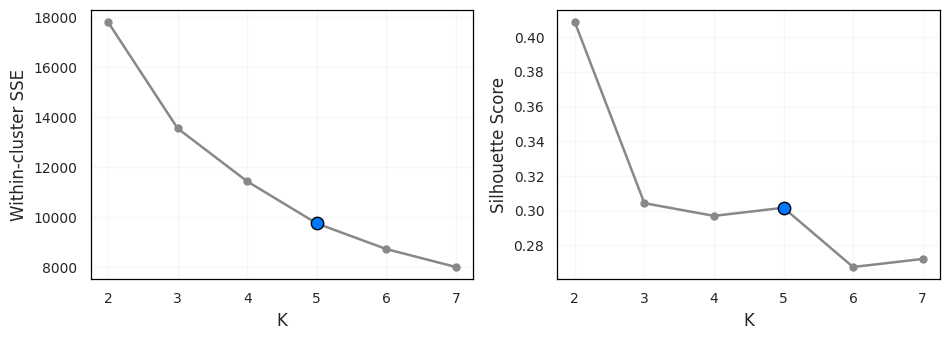

In [250]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- Data ---
X = df_scaled[cols_thermal]
K_range = range(2, 8)
inertias, silhouettes = [], []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X, kmeans.labels_))

# --- Style setup ---
sns.set_theme(style="white", font="DejaVu Sans")
plt.rcParams.update({
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.linewidth": 0.9,
    "axes.edgecolor": "black",
    "axes.spines.top": True,
    "axes.spines.right": True,
})

# --- Parameters ---
highlight_k = 5
highlight_color = "#0077FF"
line_color = "#888888"

fig, axes = plt.subplots(1, 2, figsize=(9.5, 3.4))

# --- Left: Elbow Method ---
axes[0].plot(K_range, inertias, marker="o", color=line_color, linewidth=1.8, markersize=5)
axes[0].scatter(highlight_k, inertias[K_range.index(highlight_k)],
                color=highlight_color, s=80, edgecolor="black", zorder=3)
axes[0].set_xlabel("K")
axes[0].set_ylabel("Within-cluster SSE")
axes[0].grid(alpha=0.15)
for spine in axes[0].spines.values():
    spine.set_visible(True)
    spine.set_linewidth(0.9)
    spine.set_color("black")

# --- Right: Silhouette Scores ---
axes[1].plot(K_range, silhouettes, marker="o", color=line_color, linewidth=1.8, markersize=5)
axes[1].scatter(highlight_k, silhouettes[K_range.index(highlight_k)],
                color=highlight_color, s=80, edgecolor="black", zorder=3)
axes[1].set_xlabel("K")
axes[1].set_ylabel("Silhouette Score")
axes[1].grid(alpha=0.15)
for spine in axes[1].spines.values():
    spine.set_visible(True)
    spine.set_linewidth(0.9)
    spine.set_color("black")

plt.tight_layout(pad=0.6, w_pad=1.0)
plt.show()


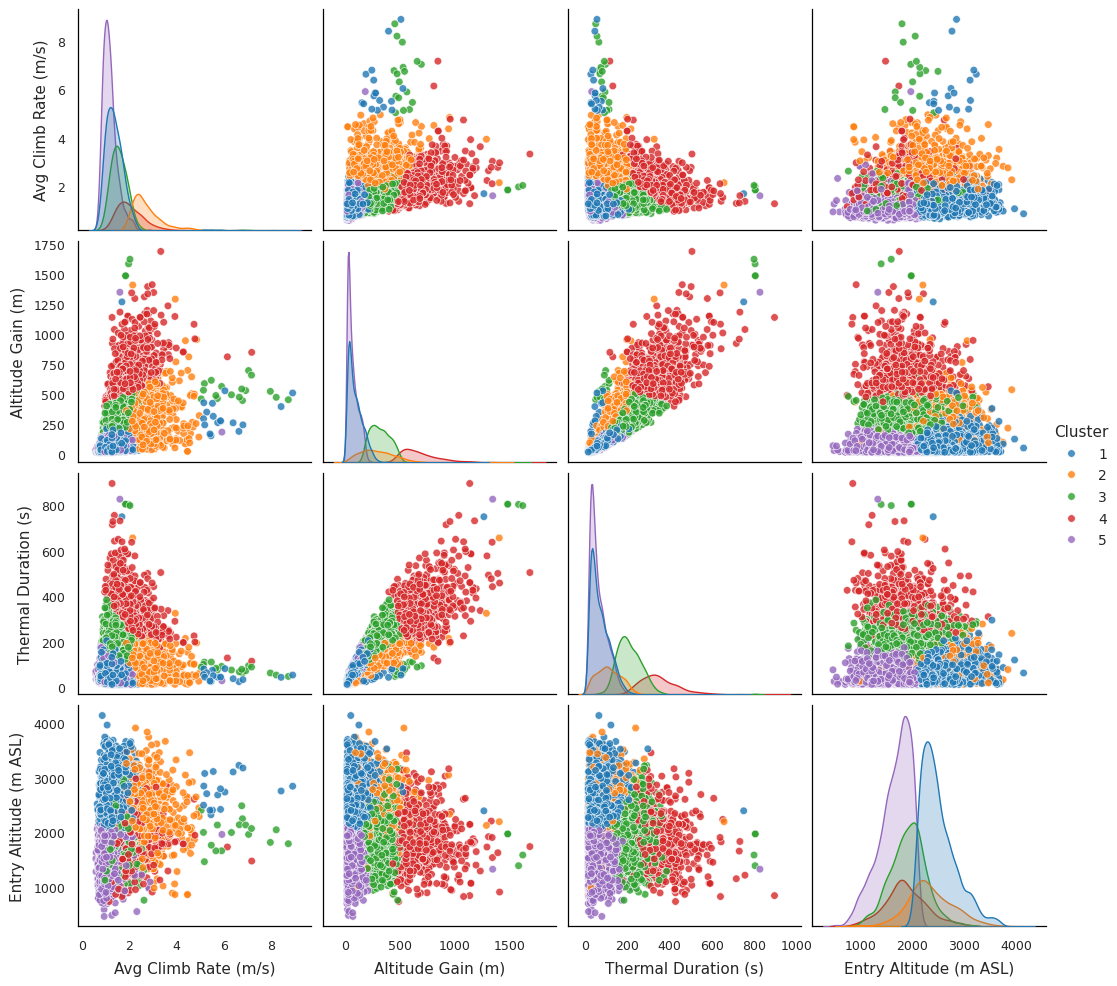

In [251]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# --- Key features and labels ---
key_features = ["avg_climb", "alt_gain", "duration_s", "entry_alt"]
rename_map = {
    "avg_climb": "Avg Climb Rate (m/s)",
    "alt_gain": "Altitude Gain (m)",
    "duration_s": "Thermal Duration (s)",
    "entry_alt": "Entry Altitude (m ASL)"
}

# --- Fit KMeans (5 clusters, labeled 1–5) ---
X = df_scaled[key_features]
kmeans = KMeans(n_clusters=5, random_state=42)
df["cluster"] = kmeans.fit_predict(X) + 1

# --- Define color palette ---
palette = sns.color_palette("tab10", 5)

# --- Pairplot with readable labels and white borders ---
g = sns.pairplot(
    df.rename(columns=rename_map),
    vars=list(rename_map.values()),
    hue="cluster",
    palette=palette,
    plot_kws=dict(s=30, alpha=0.8, edgecolor="white", linewidth=0.5)
)

# --- Larger, cleaner labels ---
for ax in g.axes.flatten():
    ax.set_xlabel(ax.get_xlabel(), fontsize=11, labelpad=6)
    ax.set_ylabel(ax.get_ylabel(), fontsize=11, labelpad=6)
    ax.tick_params(axis='both', labelsize=9)

# --- Improved legend formatting ---
leg = g._legend
leg.set_title("Cluster", prop={'size': 11})
for t in leg.texts:
    t.set_fontsize(10)
leg.set_bbox_to_anchor((1.05, 0.5))  # move legend right

# --- Tighter layout ---
plt.tight_layout(pad=1.0)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

In [252]:
cluster_summary = (
    df.groupby("cluster")[["avg_climb", "alt_gain", "duration_s", "entry_alt", "climb_std", "entry_agl","avg_turn"]]
      .median()
      .round(1)
)

# Add count
cluster_summary["count"] = df["cluster"].value_counts().sort_index()

display(cluster_summary)

,avg_climb,alt_gain,duration_s,entry_alt,climb_std,entry_agl,avg_turn,count
cluster,,,,,,,,
1,1.3,81.0,60.0,2420.0,0.6,492.0,-8.5,2227
2,2.5,279.0,107.0,2283.0,0.9,452.5,-11.4,800
3,1.5,315.0,202.0,1927.0,0.6,251.5,-9.6,1516
4,1.9,646.0,336.0,1831.0,0.8,211.0,-8.7,735
5,1.1,57.0,50.0,1718.5,0.5,189.0,-3.9,2590


Explained variance ratio: [0.537 0.294 0.155]
Cumulative variance: [0.537 0.831 0.985]


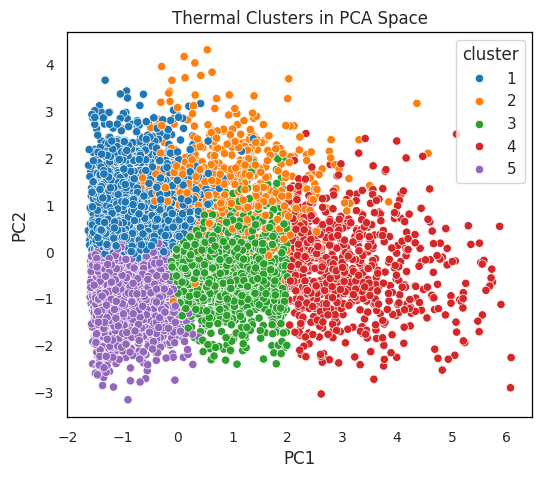

In [217]:
# PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Fit PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

print("Explained variance ratio:", pca.explained_variance_ratio_.round(3))
print("Cumulative variance:", pca.explained_variance_ratio_.cumsum().round(3))

# Plot first 2 components
plt.figure(figsize=(6,5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df["cluster"], palette="tab10")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Thermal Clusters in PCA Space")
plt.show()

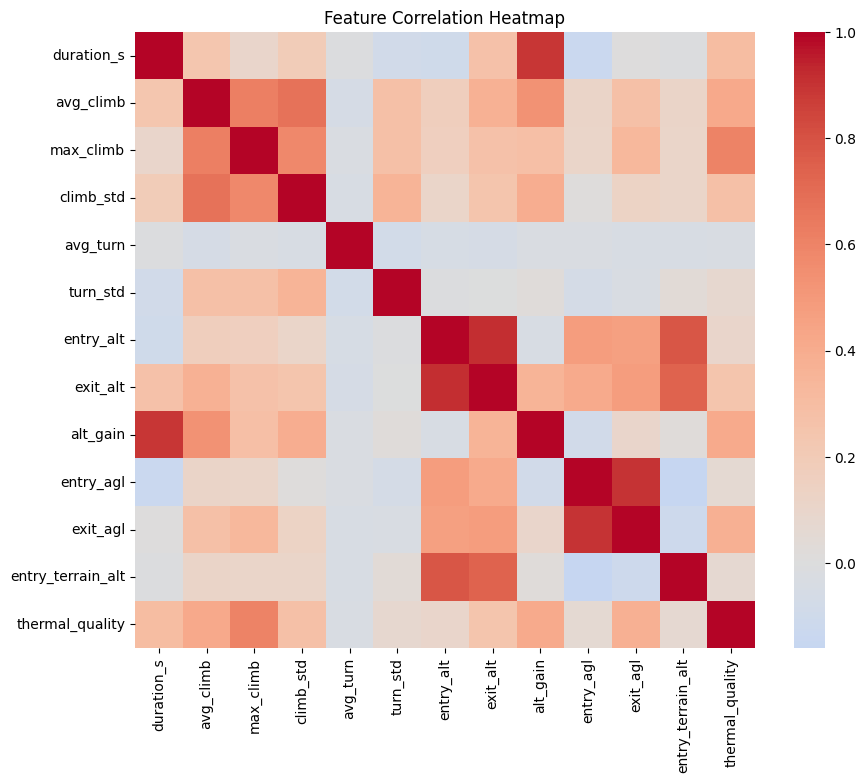

In [137]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df_scaled[cols_thermal].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="coolwarm", annot=False, center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

/var/folders/zn/2ym95l4n2131dptxjp4dk3fh0000gn/T/ipykernel_16522/1991153187.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_variance.values, y=feature_variance.index, palette="viridis")


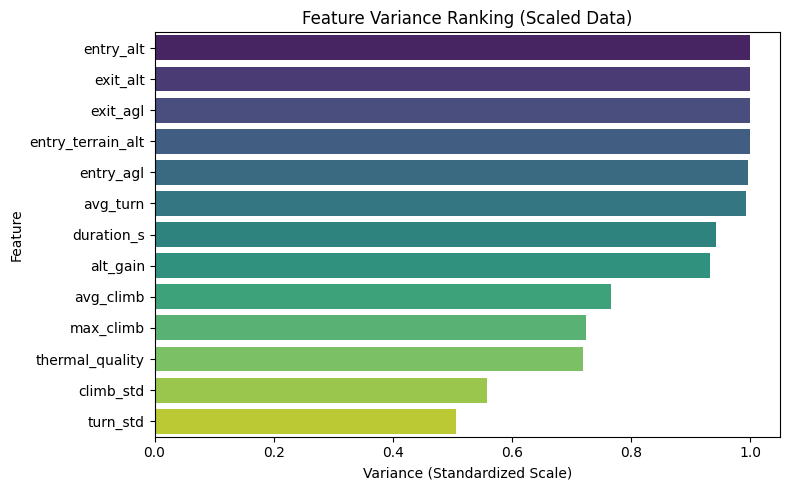

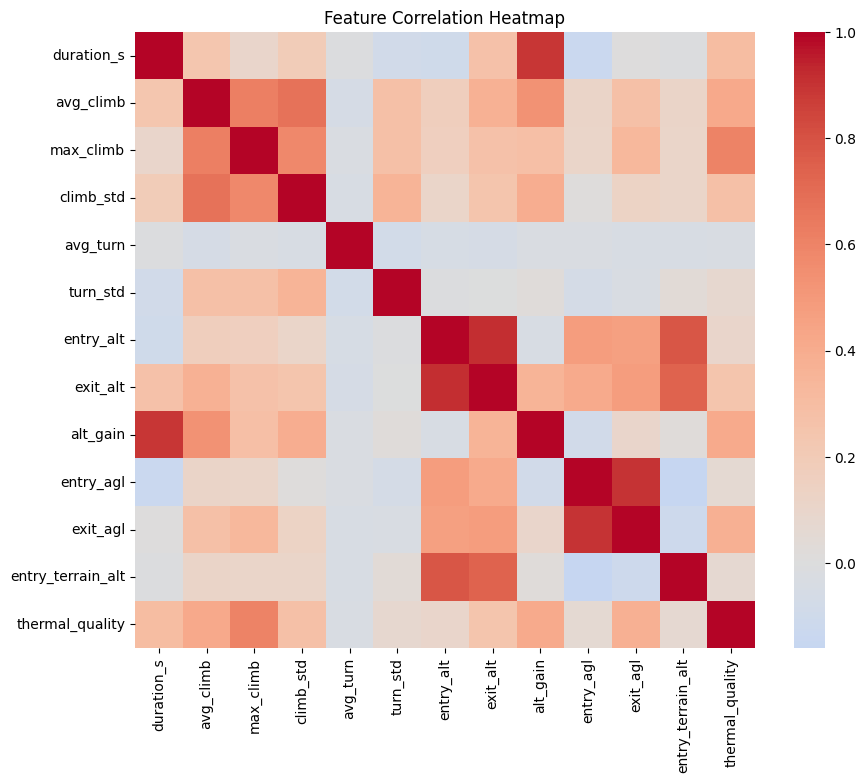

In [138]:


cols_thermal = [
    "duration_s",        # thermal lifetime
    "avg_climb",         # mean climb rate
    "max_climb",         # strongest climb
    "climb_std",         # variability in climb rate
    "avg_turn",          # average turn rate (deg/s)
    "turn_std",          # turn rate variability
    "entry_alt",         # entry altitude (ASL)
    "exit_alt",          # exit altitude (ASL)
    "alt_gain",          # total altitude gain
    "entry_agl",         # entry above ground level
    "exit_agl",          # exit above ground level
    "entry_terrain_alt", # terrain at entry
    "thermal_quality"    # optional quality metric if available
]

key_features = ["avg_climb", "alt_gain", "duration_s", "entry_alt"]

# Compute variance for each feature (on scaled data)
feature_variance = df_scaled[cols_thermal].var().sort_values(ascending=False)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=feature_variance.values, y=feature_variance.index, palette="viridis")
plt.xlabel("Variance (Standardized Scale)")
plt.ylabel("Feature")
plt.title("Feature Variance Ranking (Scaled Data)")
plt.tight_layout()
plt.show()


import seaborn as sns
import matplotlib.pyplot as plt

corr = df_scaled[cols_thermal].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="coolwarm", annot=False, center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

/var/folders/zn/2ym95l4n2131dptxjp4dk3fh0000gn/T/ipykernel_16522/3668215665.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.5)


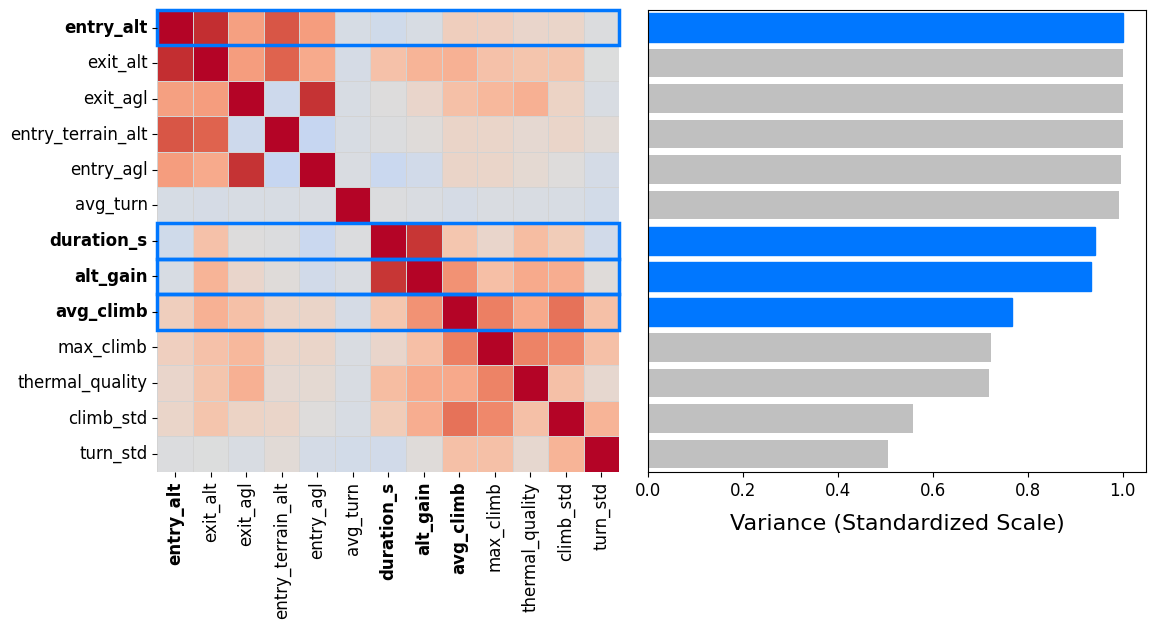

In [152]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Assumes: df_scaled, cols_thermal exist
key_features = ["avg_climb", "alt_gain", "duration_s", "entry_alt"]

# Compute correlation + variance
corr = df_scaled[cols_thermal].corr()
feature_variance = df_scaled[cols_thermal].var().sort_values(ascending=False)

# Order features by variance
order = feature_variance.index.tolist()
corr_ord = corr.reindex(index=order, columns=order)

# Colors
base_gray = "#C0C0C0"
blue = "#0077FF"

fig, axes = plt.subplots(1, 2, figsize=(13, 6), gridspec_kw={'wspace': 0.02})

# ---- LEFT: Correlation heatmap ----
sns.heatmap(
    corr_ord, cmap="coolwarm", center=0, cbar=False, ax=axes[0],
    square=True, linewidths=0.5, linecolor="lightgray"
)

# Bold tick labels for key features
for lbl in axes[0].get_xticklabels() + axes[0].get_yticklabels():
    if lbl.get_text() in key_features:
        lbl.set_fontweight("bold")
axes[0].tick_params(axis="both", labelsize=12)

# Add horizontal blue boxes around key feature rows
for i, feat in enumerate(order):
    if feat in key_features:
        y0, y1 = i, i + 1
        axes[0].add_patch(patches.Rectangle(
            (0, y0), len(order), 1, fill=False, edgecolor=blue,
            linewidth=2.5, clip_on=False
        ))

axes[0].set_title("")

# ---- RIGHT: Variance bar plot ----
sns.barplot(x=feature_variance.values, y=feature_variance.index, color=base_gray, ax=axes[1])

# Recolor bars for key features
for patch, feat in zip(axes[1].patches, feature_variance.index):
    if feat in key_features:
        patch.set_facecolor(blue)
        patch.set_edgecolor(blue)

axes[1].set_xlabel("Variance (Standardized Scale)", fontsize=16, labelpad=10)
axes[1].set_ylabel("")  # remove "Feature"
axes[1].tick_params(axis="y", left=False, labelleft=False)  # remove y labels and ticks
axes[1].tick_params(axis="x", labelsize=12)
axes[1].set_title("")

plt.tight_layout(pad=0.5)
plt.show()


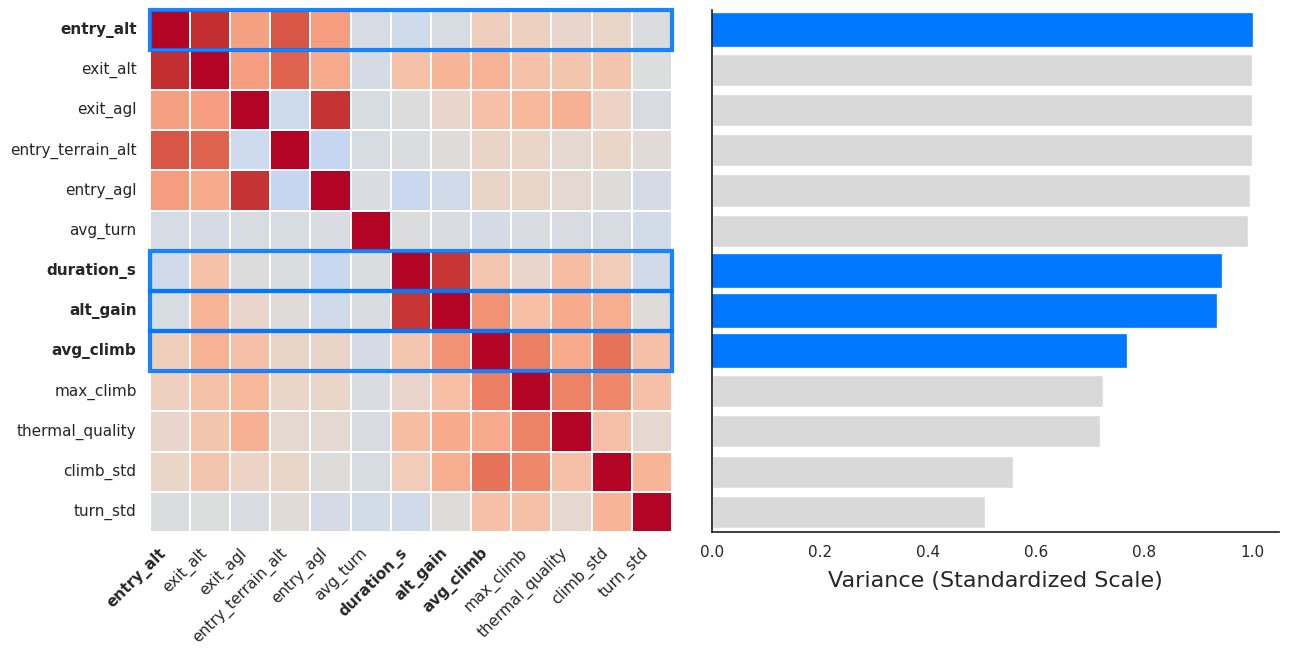

In [158]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.rcParams.update({
    "font.family": "DejaVu Sans",
    "axes.spines.top": False,
    "axes.spines.right": False
})

key_features = ["avg_climb", "alt_gain", "duration_s", "entry_alt"]

corr = df_scaled[cols_thermal].corr()
feature_variance = df_scaled[cols_thermal].var().sort_values(ascending=False)

order = feature_variance.index.tolist()
corr_ord = corr.reindex(index=order, columns=order)

# Colors
gray = "#D9D9D9"
blue = "#0077FF"

fig, axes = plt.subplots(1, 2, figsize=(12.8, 5.8), gridspec_kw={'wspace': 0.03})

# ---- LEFT: Correlation heatmap ----
sns.heatmap(
    corr_ord, cmap="coolwarm", center=0, cbar=False, ax=axes[0],
    square=True, linewidths=0.3, linecolor="white"
)

for lbl in axes[0].get_xticklabels() + axes[0].get_yticklabels():
    if lbl.get_text() in key_features:
        lbl.set_fontweight("bold")
axes[0].tick_params(axis="both", labelsize=11)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")

# Add subtle blue highlight rectangles (horizontal only)
for i, feat in enumerate(order):
    if feat in key_features:
        rect = patches.Rectangle(
            (0, i), len(order), 1, fill=False, 
            edgecolor=blue, linewidth=3, alpha=0.9, clip_on=False
        )
        axes[0].add_patch(rect)

axes[0].set_title("")

# ---- RIGHT: Variance bar plot ----
sns.barplot(x=feature_variance.values, y=feature_variance.index, color=gray, ax=axes[1])

for patch, feat in zip(axes[1].patches, feature_variance.index):
    if feat in key_features:
        patch.set_facecolor(blue)
        patch.set_edgecolor(blue)
        patch.set_linewidth(1.2)

axes[1].set_xlabel("Variance (Standardized Scale)", fontsize=16, labelpad=8)
axes[1].set_ylabel("")
axes[1].tick_params(axis="y", left=False, labelleft=False)
axes[1].tick_params(axis="x", labelsize=11)

plt.subplots_adjust(wspace=0.03, left=0.08, right=0.98, top=0.98, bottom=0.08)
plt.show()


In [24]:
from sklearn.decomposition import PCA
import pandas as pd

pca = PCA(n_components=3).fit(df_scaled[cols_thermal])
loadings = pd.DataFrame(
    pca.components_.T,
    index=cols_thermal,
    columns=["PC1", "PC2", "PC3"]
)

abs_loadings = loadings.abs()
print(abs_loadings.sort_values("PC1", ascending=False).head(10))

                        PC1       PC2       PC3
exit_alt           0.485941  0.123730  0.231926
entry_alt          0.416786  0.354550  0.236783
exit_agl           0.358849  0.184993  0.493171
avg_climb          0.281632  0.269280  0.074053
entry_agl          0.278035  0.324695  0.483734
entry_terrain_alt  0.273404  0.170009  0.608375
max_climb          0.248353  0.191875  0.123077
alt_gain           0.236367  0.506786  0.027730
thermal_quality    0.226084  0.229688  0.129129
climb_std          0.181002  0.216205  0.017550


In [25]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(df_scaled[cols_thermal], df["cluster"])
importances = pd.Series(rf.feature_importances_, index=cols_thermal)
importances.sort_values(ascending=False)

exit_alt             0.192145
alt_gain             0.182586
entry_alt            0.161725
exit_agl             0.099960
entry_agl            0.086360
duration_s           0.069365
avg_climb            0.050389
thermal_quality      0.049069
max_climb            0.034398
entry_terrain_alt    0.034116
climb_std            0.022930
turn_std             0.008976
avg_turn             0.007982
dtype: float64

In [30]:
from scipy.cluster.hierarchy import fcluster

# choose the number of clusters you decided (e.g., k = 4 or 6)
k = 4  

# assign cluster labels to df
df["hier_cluster"] = fcluster(linkage_matrix, k, criterion="maxclust")

print("✅ hier_cluster column added")
print(df["hier_cluster"].value_counts().sort_index())

outliers = df[df["hier_cluster"].isin([1, 2, 4])]
print(outliers[cols_thermal])

✅ hier_cluster column added
hier_cluster
1       2
2       1
3    1409
4    6471
Name: count, dtype: int64
      duration_s  avg_climb  max_climb  climb_std  avg_turn_radius   avg_turn  \
1             23   0.823119        1.6   0.354334        29.269215  22.050214   
2             67   1.743646        5.2   1.185881        23.452654  17.530300   
3             99   1.078976        2.4   0.563373        24.250999  10.943775   
4             99   0.863319        1.0   0.307944       -36.463323 -17.012640   
5             44   0.772727        1.8   0.414020       -45.304368 -12.428743   
...          ...        ...        ...        ...              ...        ...   
7878          44   1.201435        3.8   0.835286        52.179048  22.360012   
7879          30   1.444462        3.6   0.767783        54.397909  24.798537   
7880          15   1.262500        2.2   0.503581       -34.545109 -38.922196   
7881          56   1.304190        1.4   1.189283       -48.100767 -16.110204   
78

In [31]:
outlier_ids = df[df["hier_cluster"].isin([1, 2])].index
df.loc[outlier_ids, cols_thermal]

,duration_s,avg_climb,max_climb,climb_std,avg_turn_radius,avg_turn,turn_std,alt_gain,thermal_quality,entry_agl
1544,22,74.414058,4.8,207.775846,-15.687362,-14.855438,24.502001,24.0,18.514286,26.0
4365,36,32.481279,327.8,27.925089,-290671.888310,1.228202,11.951593,1688.0,1114.285714,-1569.0
5012,47,48.040307,390.6,83.723027,-129.412469,9.315274,11.170960,2052.0,1791.716667,-1675.0
